In [31]:
import polars as pl, numpy as np, matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import ParameterSampler
import scipy.stats as stats
import matplotlib.ticker as mticker
import pandas as pd

print(f"XGBoost version: {xgb.__version__}")

XGBoost version: 3.0.2


In [5]:
X_train = pl.read_parquet("data/X_train.parquet").drop("LSOA code").to_numpy()
y_train = pl.read_parquet("data/y_train.parquet").to_numpy().ravel()
X_test  = pl.read_parquet("data/X_test.parquet").drop("LSOA code").to_numpy()
y_test  = pl.read_parquet("data/y_test.parquet").to_numpy().ravel()

In [67]:
my_model = XGBRegressor()
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [74]:
predictions = my_model.predict(X_test)
predictions_rounded = np.round(predictions).astype(int)

print("=" * 10 + " Base Model Evaluation " + "=" * 10)
print(f"{'Mean Squared Error':<25}: {mean_squared_error(y_test, predictions):>10.4f}")
print(f"{'Root Mean Squared Error':<25}: {np.sqrt(mean_squared_error(y_test, predictions)):>10.4f}")
print(f"{'Mean Absolute Error':<25}: {mean_absolute_error(y_test, predictions):>10.4f}")
print(f"{'R²':<25}: {r2_score(y_test, predictions):>10.4f}")
print(f"{'Explained variance':<25}: {explained_variance_score(y_test, predictions):>10.4f}")
print("=" * 43)

========== Base Model Evaluation ==========
Mean Squared Error       :     1.2182
Root Mean Squared Error  :     1.1037
Mean Absolute Error      :     0.7792
R²                       :     0.2714
Explained variance       :     0.2756


In [6]:
optimized_model = XGBRegressor(
    colsample_bytree=0.679486272613669,
    learning_rate=0.16678305712187014,
    max_depth=4,
    min_child_weight=8,
    n_estimators=468,
    subsample=0.9085081386743783,
    objective="count:poisson",
    eval_metric="rmse",
    tree_method="hist",
    random_state=42,
    early_stopping_rounds=72,
    n_jobs=-1
)

adjusted_model = optimized_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

In [7]:
opt_predictions = adjusted_model.predict(X_test)

print("=" * 10 + " Optimized Model Evaluation " + "=" * 10)
print(f"{'Mean Squared Error':<25}: {mean_squared_error(y_test, opt_predictions):>10.4f}")
print(f"{'Root Mean Squared Error':<25}: {np.sqrt(mean_squared_error(y_test, opt_predictions)):>10.4f}")
print(f"{'Mean Absolute Error':<25}: {mean_absolute_error(y_test, opt_predictions):>10.4f}")
print(f"{'R²':<25}: {r2_score(y_test, opt_predictions):>10.4f}")
print(f"{'Explained variance':<25}: {explained_variance_score(y_test, opt_predictions):>10.4f}")
print("=" * 48)

========== Optimized Model Evaluation ==========
Mean Squared Error       :     1.1716
Root Mean Squared Error  :     1.0824
Mean Absolute Error      :     0.7810
R²                       :     0.2992
Explained variance       :     0.3010


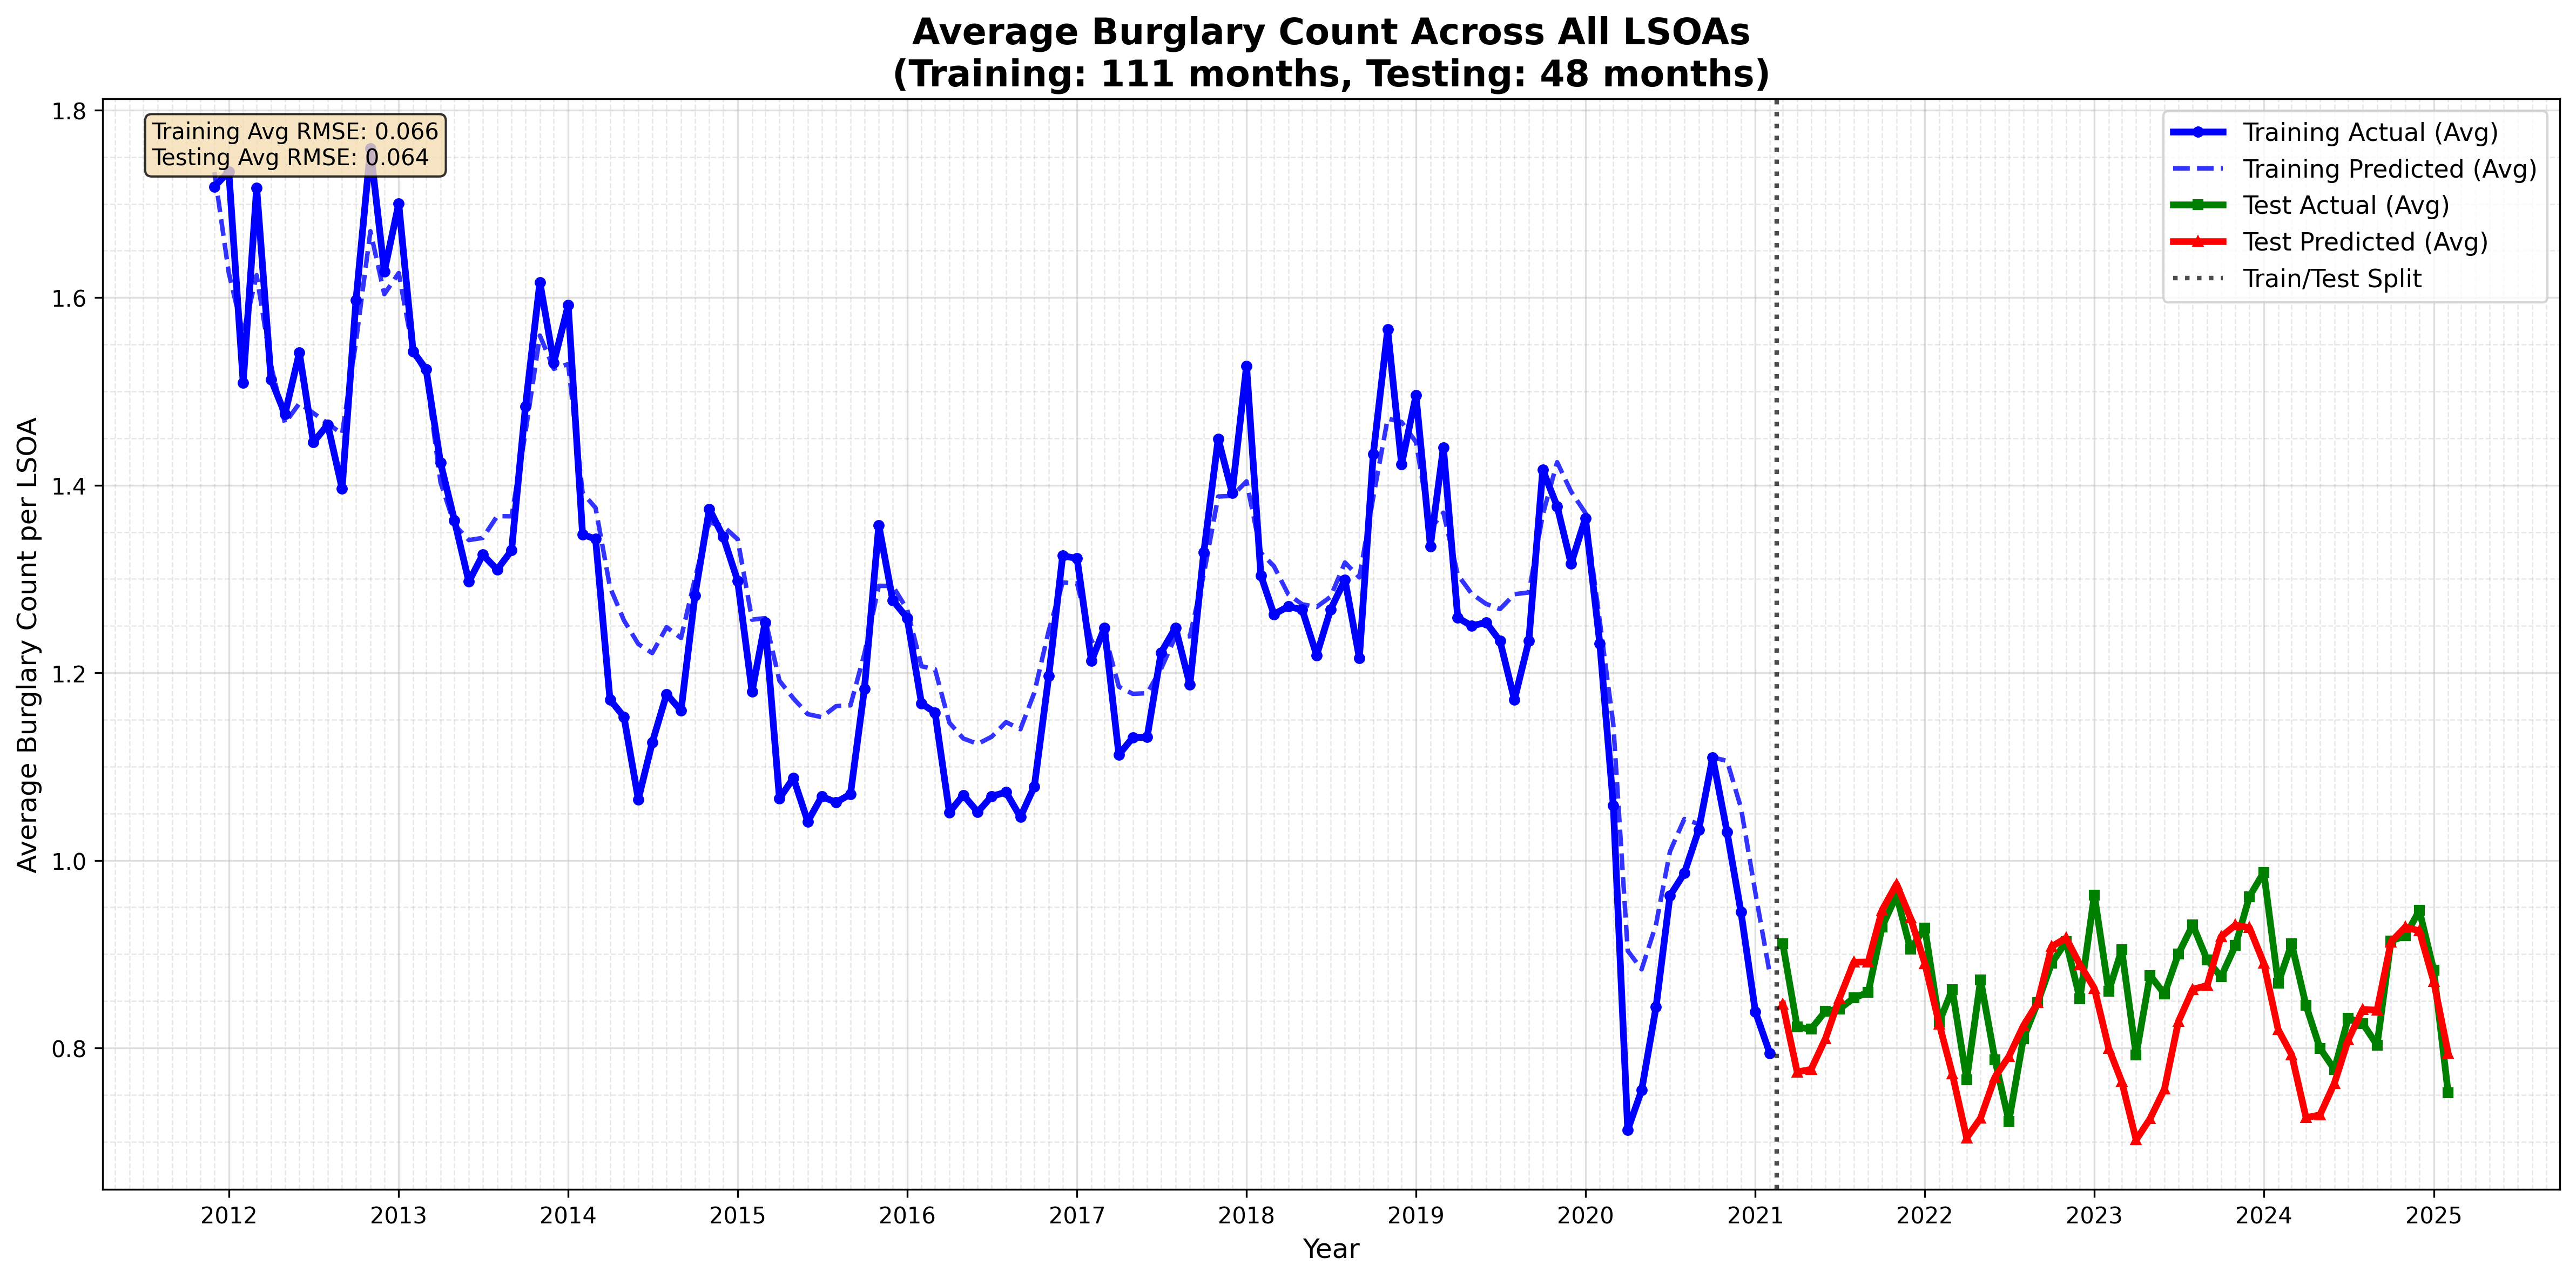


AVERAGE LSOA STATISTICS
Training Period Average:
  Avg Actual per LSOA per month:    1.271
  Avg Predicted per LSOA per month: 1.300
  Training Avg RMSE:                0.066

Testing Period Average:
  Avg Actual per LSOA per month:    0.867
  Avg Predicted per LSOA per month: 0.837
  Testing Avg RMSE:                 0.064

Seasonal Pattern (Training Data):
  Jan: 1.413 avg burglaries per LSOA
  Feb: 1.262 avg burglaries per LSOA
  Mar: 1.334 avg burglaries per LSOA
  Apr: 1.176 avg burglaries per LSOA
  May: 1.172 avg burglaries per LSOA
  Jun: 1.160 avg burglaries per LSOA
  Jul: 1.191 avg burglaries per LSOA
  Aug: 1.199 avg burglaries per LSOA
  Sep: 1.186 avg burglaries per LSOA
  Oct: 1.324 avg burglaries per LSOA
  Nov: 1.414 avg burglaries per LSOA
  Dec: 1.390 avg burglaries per LSOA


In [33]:
train_df = pl.read_parquet("data/X_train.parquet").with_columns(
    pl.read_parquet("data/y_train.parquet")
)
test_df = pl.read_parquet("data/X_test.parquet").with_columns(
    pl.read_parquet("data/y_test.parquet")
)

# Get predictions
train_predictions = adjusted_model.predict(X_train)
test_predictions = adjusted_model.predict(X_test)

# Round the predictions
train_predictions = np.round(train_predictions).astype(int)
test_predictions = np.round(test_predictions).astype(int)

# Add predictions to dataframes
train_df = train_df.with_columns(pl.Series("predictions", train_predictions))
test_df = test_df.with_columns(pl.Series("predictions", test_predictions))

train_avg = (
    train_df
    .group_by(["time_index_norm", "year", "month"])
    .agg([
        pl.col("burglary_count").mean().alias("avg_actual"),
        pl.col("predictions").mean().alias("avg_predicted")
    ])
    .sort("time_index_norm")
)

test_avg = (
    test_df
    .group_by(["time_index_norm", "year", "month"])
    .agg([
        pl.col("burglary_count").mean().alias("avg_actual"),
        pl.col("predictions").mean().alias("avg_predicted")
    ])
    .sort("time_index_norm")
)

train_dates = pd.to_datetime({"year": train_avg["year"], "month": train_avg["month"], "day": 1})
test_dates  = pd.to_datetime({"year": test_avg["year"],  "month": test_avg["month"],  "day": 1})

train_actual_avg = train_avg["avg_actual"].to_list()
train_pred_avg   = train_avg["avg_predicted"].to_list()
test_actual_avg  = test_avg["avg_actual"].to_list()
test_pred_avg    = test_avg["avg_predicted"].to_list()

fig, ax = plt.subplots(figsize=(16, 8), dpi=300)

ax.plot(train_dates, train_actual_avg,  'b-', linewidth=3, label='Training Actual (Avg)',  marker='o', markersize=4)
ax.plot(train_dates, train_pred_avg,    'b--', linewidth=2, alpha=0.8, label='Training Predicted (Avg)')
ax.plot(test_dates,  test_actual_avg,   'g-', linewidth=3, label='Test Actual (Avg)',      marker='s', markersize=4)
ax.plot(test_dates,  test_pred_avg,     'r-', linewidth=3, label='Test Predicted (Avg)',   marker='^', markersize=4)

# vertical split line at the boundary between the two date series
ax.axvline(train_dates.iloc[-1] + pd.Timedelta(days=15), color='black',
           linestyle=':', alpha=0.7, linewidth=2, label='Train/Test Split')

# date-axis formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=1, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
fig.autofmt_xdate(ha='center', rotation=0)

ax.set_title('Average Burglary Count Across All LSOAs\n(Training: 111 months, Testing: 48 months)',
             fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Average Burglary Count per LSOA', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.4)
ax.grid(True, which='major', linestyle='-',  linewidth=0.8, alpha=0.4)
ax.grid(True, which='minor', linestyle='--', linewidth=0.6, alpha=0.3)
ax.tick_params(axis='both', which='minor', length=0)
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())

# Add some statistics as text
train_rmse = np.sqrt(np.mean((np.array(train_actual_avg) - np.array(train_pred_avg))**2))
test_rmse = np.sqrt(np.mean((np.array(test_actual_avg) - np.array(test_pred_avg))**2))

plt.text(0.02, 0.98, f'Training Avg RMSE: {train_rmse:.3f}\nTesting Avg RMSE: {test_rmse:.3f}',
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

# Print average statistics
print("\n" + "="*50)
print("AVERAGE LSOA STATISTICS")
print("="*50)
print(f"Training Period Average:")
print(f"  Avg Actual per LSOA per month:    {np.mean(train_actual_avg):.3f}")
print(f"  Avg Predicted per LSOA per month: {np.mean(train_pred_avg):.3f}")
print(f"  Training Avg RMSE:                {train_rmse:.3f}")

print(f"\nTesting Period Average:")
print(f"  Avg Actual per LSOA per month:    {np.mean(test_actual_avg):.3f}")
print(f"  Avg Predicted per LSOA per month: {np.mean(test_pred_avg):.3f}")
print(f"  Testing Avg RMSE:                 {test_rmse:.3f}")

# Show seasonal patterns in the average
monthly_pattern = []
for month in range(1, 13):
    month_data = train_df.filter(pl.col("month") == month)
    if len(month_data) > 0:
        avg_burglaries = month_data.select("burglary_count").mean().item()
        monthly_pattern.append((month, avg_burglaries))

if monthly_pattern:
    print(f"\nSeasonal Pattern (Training Data):")
    for month, avg in monthly_pattern:
        month_names = ["", "Jan", "Feb", "Mar", "Apr", "May", "Jun",
                      "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
        print(f"  {month_names[month]:3s}: {avg:.3f} avg burglaries per LSOA")